# Parametric Cells

Problem:

In GDS format

- each component must have a unique name. Ideally the name is also consitent from different run times, in case you want to merge GDS files that were created at different times or computers.
- two components stored in the GDS file cannot have the same name. Ideally they will be references to the same component. See `References tutorial`. That way we only have to store that component in memory once and all the references are just pointers to that component.

Solution: The decorator `@gf.cell` addresses all these issues:

1. Gives the component a unique name depending on the parameters that you pass to it.
2. Creates a cache of components where we use the name as the key. The first time the function runs, the cache stores the component, so the second time, you get the component directly from the cache, so you don't create the same component twice.


Also, thanks to the @cell decorator, GDS cells in gdsfactory include an `metadata` dictionary where you can access all component settings:

- `changed` settings used to create the component
- `default` settings in function signature
- `full` full settings
- name
- function_name
- module

`@cell` comes from PCell `parametric cell` that returns a different Component depending on the input parameters.

Make sure that your components get good names by adding the `@cell` decorator to that each function that returns a component.

Lets see how it works.

In [1]:
import gdsfactory as gf

# gf.CONF.plotter = 'holoviews'


@gf.cell
def wg(length=10, width=1, layer=(1, 0)):
    print("BUILDING waveguide")
    c = gf.Component()
    c.add_polygon([(0, 0), (length, 0), (length, width), (0, width)], layer=layer)
    c.add_port(
        name="o1", midpoint=[0, width / 2], width=width, orientation=180, layer=layer
    )
    c.add_port(
        name="o2", midpoint=[length, width / 2], width=width, orientation=0, layer=layer
    )
    return c

2022-05-31 23:05:41.392 | INFO     | gdsfactory.config:<module>:52 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 5.8.3


See how the cells get the name from the parameters that you pass them

In [2]:
c = wg()
print(c)

# The second time you will get this cell from the cache
c = wg()
print(c)

# If you call the cell with different parameters, the cell will get a different name
c = wg(width=0.5)
print(c)

BUILDING waveguide
wg: uid 0, ports ['o1', 'o2'], aliases [], 1 polygons, 0 references
wg: uid 0, ports ['o1', 'o2'], aliases [], 1 polygons, 0 references
BUILDING waveguide
wg_d6e1c0cf: uid 1, ports ['o1', 'o2'], aliases [], 1 polygons, 0 references


Sometimes when you are changing the inside code of the function, you need to **ignore** the cache.
you can pass `cache=False`

In [3]:
c = wg(cache=False)

BUILDING waveguide


In [4]:
c.metadata.changed

{}

In [5]:
c.metadata.default

{'length': 10, 'width': 1, 'layer': [1, 0]}

In [6]:
c.metadata.full

{'length': 10, 'width': 1, 'layer': [1, 0]}

In [7]:
c.pprint()

name: wg
settings:
  changed: {}
  child: null
  default:
    layer:
    - 1
    - 0
    length: 10
    width: 1
  full:
    layer:
    - 1
    - 0
    length: 10
    width: 1
  function_name: wg
  info: {}
  info_version: 2
  module: __main__
  name: wg
version: 0.0.1



thanks to `gf.cell` you can also add any metadata `info` relevant to the cell

In [8]:
c = wg(length=3, info=dict(polarization="te", wavelength=1.55))

BUILDING waveguide


In [9]:
c.pprint()

name: wg_2dcab9f2
settings:
  changed:
    length: 3
  child: null
  default:
    layer:
    - 1
    - 0
    length: 10
    width: 1
  full:
    layer:
    - 1
    - 0
    length: 3
    width: 1
  function_name: wg
  info:
    polarization: te
    wavelength: 1.55
  info_version: 2
  module: __main__
  name: wg_2dcab9f2
version: 0.0.1



In [10]:
print(c.metadata.info.wavelength)

1.55


## Metadata

Together with the GDS files that you send to the foundry you can also store some metadata in YAML for each cell containing all the settings that we used to build the GDS.

the metadata will consists of all the parameters that were passed to the component function as well as derived properties

- settings: includes all component metadata
    - derived properties
    - external metadata (test_protocol, docs, ...)
    - simulation_settings
    - function_name
    - name: for the component
    - name_long: for the component
    - full: full list of settings
    - changed: changed settings
    - default: includes the default signature of the component
- ports: port name, width, orientation


How can you have add two different references to a cell with the same parameters?

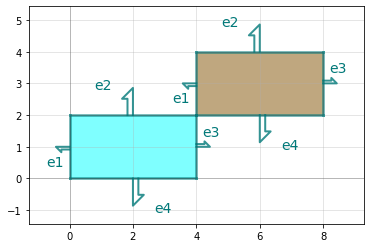

problem: uid 4, ports [], aliases [], 0 polygons, 2 references

In [11]:
import gdsfactory as gf

c = gf.Component("problem")
R1 = gf.components.rectangle(
    size=(4, 2), layer=(2, 0)
)  # Creates a rectangle (same Unique ID uid)
R2 = gf.components.rectangle(size=(4, 2), layer=(3, 0))
# Try Create a new rectangle that we want to change (but has the same name so we will get R1 from the cache)

r1r = c << R1  # Add the first rectangle to c
r2r = c << R2  # Add the second rectangle to c
r2r.move((4, 2))
c

In [12]:
print(R1 == R2)
print(R1)
print(R2)

False
rectangle_5be13441: uid 5, ports ['e1', 'e2', 'e3', 'e4'], aliases [], 0 polygons, 1 references
rectangle_3b71599f: uid 7, ports ['e1', 'e2', 'e3', 'e4'], aliases [], 0 polygons, 1 references


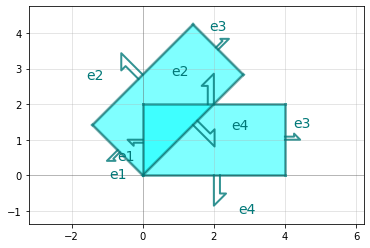

solution: uid 9, ports [], aliases [], 0 polygons, 2 references

In [13]:
# lets do it cleaner with references
import gdsfactory as gf

c = gf.Component("solution")
R = gf.components.rectangle(size=(4, 2), layer=(2, 0))

r1 = c << R  # Add the first rectangle reference to c
r2 = c << R  # Add the second rectangle reference to c

r2.rotate(45)
c

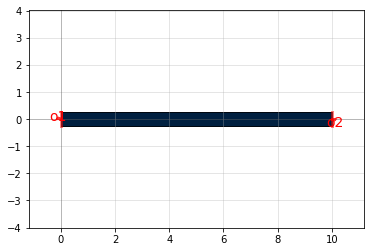

straight: uid 10, ports ['o1', 'o2'], aliases [], 4 polygons, 0 references

In [14]:
import gdsfactory as gf

c = gf.components.straight()
c.show()
c

We can even show ports of all references with `component.show(show_subports=True)`

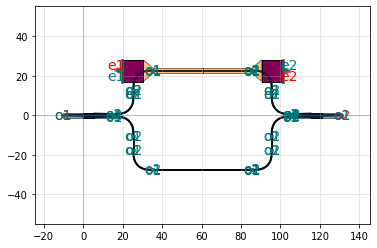

mzi_26978741: uid 15, ports ['o1', 'o2', 'e1', 'e2'], aliases [], 0 polygons, 20 references

In [15]:
c = gf.components.mzi_phase_shifter(length_x=50)
c

## Cache

To avoid that 2 exact cells are not references of the same cell the `cell` decorator has a
cache where if a component has already been built it will return the component
from the cache


In [16]:
@gf.cell
def wg(length=10, width=1):
    c = gf.Component()
    c.add_polygon([(0, 0), (length, 0), (length, width), (0, width)], layer=(1, 0))
    print("BUILDING waveguide")
    return c

In [17]:
gf.clear_cache()

wg1 = wg()  # cell builds a straight
print(wg1)

BUILDING waveguide
wg: uid 48, ports [], aliases [], 1 polygons, 0 references


In [18]:
wg2 = wg()
# cell returns the same straight as before without having to run the function
print(wg2)  # notice that they have the same uuid (unique identifier)

wg: uid 48, ports [], aliases [], 1 polygons, 0 references


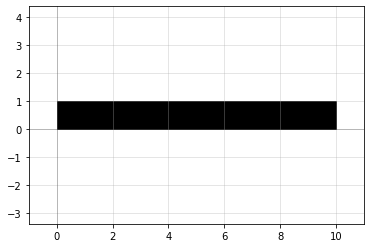

wg: uid 48, ports [], aliases [], 1 polygons, 0 references

In [19]:
wg2

In [20]:
from gdsfactory.cell import print_cache

Lets say that you change the code of the straight function in a jupyter notebook like this one.  (I mostly use Vim/VsCode/Pycharm for creating new cells in python)

In [21]:
print_cache()

wg


In [22]:
wg3 = wg()
wg4 = wg(length=11)

BUILDING waveguide


In [23]:
print_cache()

wg
wg_0723ff82


In [24]:
gf.clear_cache()

To enable nice notebook tutorials, every time we show a cell in Matplotlib or Klayout, you can clear the cache,

in case you want to develop cells in jupyter notebooks or an IPython kernel

In [25]:
print_cache()  # cache is now empty

## Validate argument types

By default, also `@cell` validates arguments based on their type annotations.
To make sure you pass the correct arguments to the cell function it runs a validator that checks the type annotations for the function.


For example this will be correct

```python
import gdsfactory as gf

@gf.cell
def straigth_waveguide(length:float):
    return gf.components.straight(length=length)


component = straigth_waveguide(length=3)
```

While this will raise an error, because you are passing a length that is a string, so it cannot convert it to a float


```python
component = straigth_waveguide(length='long')
```

```bash
ValidationError: 1 validation error for StraigthWaveguide
length
  value is not a valid float (type=type_error.float)

```

by default `@cell` validates all arguments using [pydantic](https://pydantic-docs.helpmanual.io/usage/validation_decorator/#argument-types)

In [26]:
@gf.cell
def straigth_waveguide(length: float):
    print(type(length))
    return gf.components.straight(length=length)


# It will also convert an `int` to a `float`
c = straigth_waveguide(length=3)

<class 'float'>
